## Benchmarking

In [5]:
import pandas as pd
import numpy as np

In [6]:
%matplotlib inline

The NBA data is included in a compressed format because it's pretty big. Uncomment the line below to unzip.

In [19]:
# !tar -xzvf data/nba.tar.gz -C data/

nba.csv


In [20]:
df = pd.read_csv('data/nba.csv')
df['date'] = pd.to_datetime(df['GAME_DATE'])
df.sort_values(by=['date'], inplace=True)
df.head()

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,Season,date
559702,1996-97,239,Darrick Martin,1610612746,LAC,Los Angeles Clippers,29600013,1996-11-01,LAC @ GSW,W,...,1,3,0,13,7,19.7,0,0,1996-97,1996-11-01
559506,1996-97,63,Michael Smith,1610612758,SAC,Sacramento Kings,29600009,1996-11-01,SAC @ HOU,L,...,0,4,0,8,-10,23.5,0,0,1996-97,1996-11-01
559507,1996-97,251,Sean Elliott,1610612759,SAS,San Antonio Spurs,29600008,1996-11-01,SAS @ MIN,L,...,4,3,0,14,-11,29.1,0,0,1996-97,1996-11-01
559508,1996-97,112,Dontonio Wingfield,1610612757,POR,Portland Trail Blazers,29600014,1996-11-01,POR @ VAN,W,...,1,6,0,4,16,29.8,0,0,1996-97,1996-11-01
559509,1996-97,210,Terrell Brandon,1610612739,CLE,Cleveland Cavaliers,29600002,1996-11-01,CLE @ NJN,W,...,1,4,0,25,15,45.7,0,0,1996-97,1996-11-01


In [21]:
df.shape

(559703, 37)

In [38]:
def make_features(player_df, focus='PTS'):
    player_df = player_df.assign(
        target=player_df[focus].shift(-1),
        sample_mean=player_df[focus].expanding().mean(),
        ewma=player_df[focus].ewm(alpha=0.1).mean(),
        last_day=player_df[focus],
        moving_window=player_df[focus].expanding(10).mean(),
        home=player_df['MATCHUP'].shift(-1).apply(lambda x: x if type(x)==np.float else int(x.split()[1]=='vs.'))
    )
    
    features = ['date', 'last_day', 'sample_mean', 'moving_window', 'ewma', 'home', 'target']
    
    #     features = pdf[cat_features + date_features + cont_features + stat_features].copy()
    features = player_df[features].copy()
    features = features[10:-1] # drop rows with missing data
    return features

In [39]:
# Split the df by player, generate the features, then recombine into a single df
combined = None

for player in df['PLAYER_ID'].unique():
    player_df = df[df['PLAYER_ID']==player].reset_index(drop=True)
    features = make_features(player_df)
    if combined is None: combined = features
    else: combined = pd.concat([combined, features])

In [40]:
combined.head()

,date,last_day,sample_mean,moving_window,ewma,home,target
10,1996-11-21,7,5.090909,5.090909,5.084948,0.0,4.0
11,1996-11-23,4,5.000000,5.000000,4.933751,1.0,5.0
12,1996-11-25,5,5.000000,5.000000,4.942634,1.0,18.0
13,1996-11-27,18,5.928571,5.928571,6.635687,0.0,18.0
14,1996-11-29,18,6.733333,6.733333,8.066764,1.0,12.0


In [28]:
combined.shape

(537795, 6)

In [29]:
def mae(targ, pred): return (pred-targ).abs().mean()

In [30]:
mae(combined['target'], combined['last_day'])

5.551758569715226

In [31]:
mae(combined['target'], combined['sample_mean'])

4.9634851880663335

In [32]:
mae(combined['target'], combined['ewma'])

4.319840755362905

In [33]:
mae(combined['target'], combined['moving_window'])

4.9634851880663335

The averaging techniques perform better than looking at the last day. This may suggest that the player has an underlying level of skill that is predictive of points, and short-term blips are not very telling. The exponentially weighted average performs best, perhaps because it's able to pick up on trends such as a player improving or getting worse.

## XGBoost

In [48]:
import xgboost as xgb

In [41]:
combined = combined.sort_values(by='date').reset_index(drop=True)

In [42]:
combined.head()

,date,last_day,sample_mean,moving_window,ewma,home,target
0,1996-11-17,11,16.818182,16.818182,16.445124,1.0,20.0
1,1996-11-17,10,7.090909,7.090909,6.909297,1.0,3.0
2,1996-11-17,6,8.909091,8.909091,8.480440,1.0,6.0
3,1996-11-17,4,4.272727,4.272727,4.283124,1.0,6.0
4,1996-11-17,18,9.727273,9.727273,9.540422,1.0,14.0


In [50]:
combined.drop(columns='date', inplace=True)

In [52]:
split = int(len(combined) * .75); split

403346

In [53]:
combined_train = combined.iloc[:split]
combined_test = combined.iloc[split:]

In [54]:
combined_train.shape, combined_test.shape

((403346, 6), (134449, 6))

In [55]:
X_train = combined_train.drop(columns=['target'])
y_train = combined_train['target']

X_test = combined_test.drop(columns=['target'])
y_test = combined_test['target']

In [56]:
# training model; may take several minutes
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
       verbose=False)

/opt/conda/envs/fastai/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/envs/fastai/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:14:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 2min 43s, sys: 268 ms, total: 2min 44s
Wall time: 2min 44s


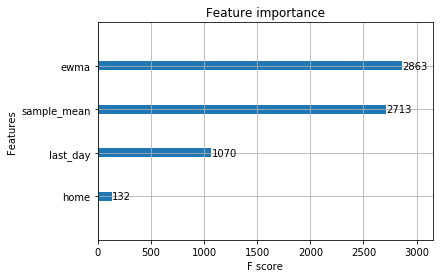

In [58]:
xgb.plot_importance(reg)

In [59]:
preds = reg.predict(X_test)

In [60]:
mae(y_test, preds)

4.39131847486197

## fastai

In [61]:
df = pd.read_csv('data/nba.csv')
df['date'] = pd.to_datetime(df['GAME_DATE'])
df.sort_values(by=['date'], inplace=True)

In [62]:
df.head()

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,Season,date
559702,1996-97,239,Darrick Martin,1610612746,LAC,Los Angeles Clippers,29600013,1996-11-01,LAC @ GSW,W,...,1,3,0,13,7,19.7,0,0,1996-97,1996-11-01
559506,1996-97,63,Michael Smith,1610612758,SAC,Sacramento Kings,29600009,1996-11-01,SAC @ HOU,L,...,0,4,0,8,-10,23.5,0,0,1996-97,1996-11-01
559507,1996-97,251,Sean Elliott,1610612759,SAS,San Antonio Spurs,29600008,1996-11-01,SAS @ MIN,L,...,4,3,0,14,-11,29.1,0,0,1996-97,1996-11-01
559508,1996-97,112,Dontonio Wingfield,1610612757,POR,Portland Trail Blazers,29600014,1996-11-01,POR @ VAN,W,...,1,6,0,4,16,29.8,0,0,1996-97,1996-11-01
559509,1996-97,210,Terrell Brandon,1610612739,CLE,Cleveland Cavaliers,29600002,1996-11-01,CLE @ NJN,W,...,1,4,0,25,15,45.7,0,0,1996-97,1996-11-01


## Make data
First I split the df by player (each player is really their own time series). Then I generate the training data as follows: X is 10 contiguous games, y is the game immediately after that (11th game). Do this as many times as the player series allows, stepping forward one day each time. This does mean there's a lot of overlap between the samples - I don't know if that's a problem. I split train/valid/test by season, partly for convenience, partly because I'm worried that the overlap in the samples could allow some data leakage. Because the test set is a season the model hasn't seen at all, the score on the test set should at least be a fair measure of how well it's working.

In [ ]:
def make_arrays(player_df, window=10):
    pts=player_df['PTS']
    xs,ys = [],[]
    for start in range(len(pts) - window):
        end = start + window
        x = pts[start:end]
        y = pts[end]
        xs.append(x)
        ys.append(y)
    return xs,ys

In [ ]:
def make_data(df):
    all_xs, all_ys = [],[]
    for player in df['PLAYER_ID'].unique():
        player_df = df[df['PLAYER_ID']==player].reset_index(drop=True)
        player_xs, player_ys = make_arrays(player_df)
        all_xs += player_xs
        all_ys += player_ys

    X = np.array(all_xs).astype('float32')
    X = X[:,np.newaxis,:]
    y = np.array(all_ys).astype('float32')
    return X, y

In [65]:
train_df = df[df['SEASON_YEAR'].isin(['2016-17', '2015-16', '2014-15'])].reset_index(drop=True)
valid_df = df[df['SEASON_YEAR']=='2017-18'].reset_index(drop=True)
test_df = df[df['SEASON_YEAR']=='2018-19'].reset_index(drop=True)

In [66]:
X_train, y_train = make_data(train_df)
X_valid, y_valid = make_data(valid_df)
X_test, y_test = make_data(test_df)

In [67]:
list(map(lambda x: x.shape, (X_train, y_train, X_valid, y_valid, X_test, y_test)))

[(71833, 1, 10), (71833,), (21144, 1, 10), (21144,), (21168, 1, 10), (21168,)]

In [68]:
import fastai, os
from fastai_timeseries import *
from torchtimeseries.models import *
path = Path(os.getcwd())
print(path)
print('fastai :', fastai.__version__)
print('torch  :', torch.__version__)
print('device :', device)

/storage/timeseriesAI
fastai : 1.0.58
torch  : 1.0.0
device : cuda


In [69]:
bs = 64                            # ✳️
seed = 1234                        # ✳️
scale_type = 'standardize'         # ✳️ 'standardize', 'normalize'
scale_subtype = 'per_channel'      # ✳️ 'all_samples', 'per_channel', 'per_sample'
scale_range = (-1, 1)              # ✳️ for normalization only: usually left to (-1, 1)

In [70]:
db = (ItemLists('.', TimeSeriesList(X_train), TimeSeriesList(X_valid))
      .label_from_lists(y_train, y_valid)
      .databunch(bs=min(bs, len(X_train)), val_bs=min(len(X_valid), bs * 2), num_workers=cpus, device=device)
      .scale(scale_type=scale_type, scale_subtype=scale_subtype, scale_range=scale_range)
     )
db

TSDataBunch;

Train: LabelList (71833 items)
x: TimeSeriesList
TimeSeries(ch=1, seq_len=10),TimeSeries(ch=1, seq_len=10),TimeSeries(ch=1, seq_len=10),TimeSeries(ch=1, seq_len=10),TimeSeries(ch=1, seq_len=10)
y: FloatList
0.0,9.0,2.0,9.0,8.0
Path: .;

Valid: LabelList (21144 items)
x: TimeSeriesList
TimeSeries(ch=1, seq_len=10),TimeSeries(ch=1, seq_len=10),TimeSeries(ch=1, seq_len=10),TimeSeries(ch=1, seq_len=10),TimeSeries(ch=1, seq_len=10)
y: FloatList
3.0,11.0,11.0,9.0,0.0
Path: .;

Test: None

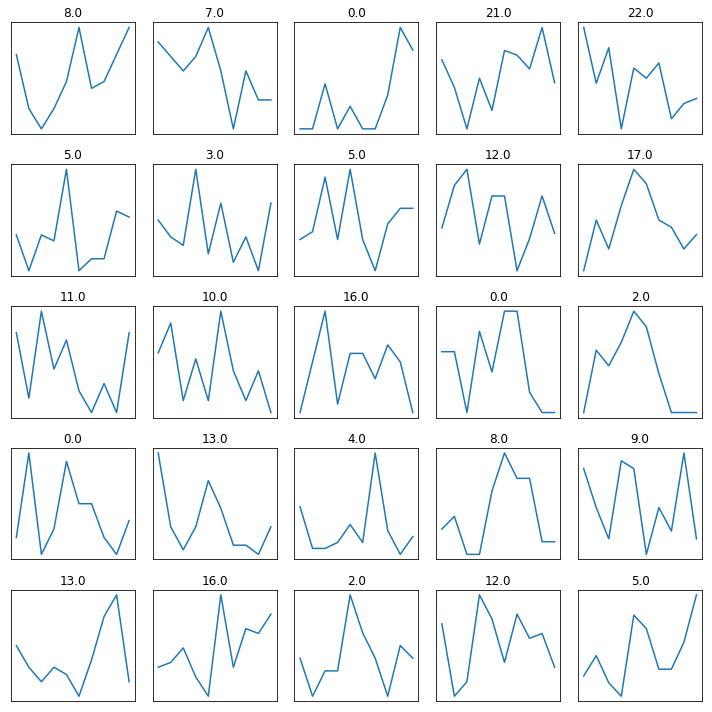

In [71]:
db.show_batch()

In [72]:
from torchtimeseries.models import *
# Select one arch from these state-of-the-art time series/ 1D models:
# ResCNN, FCN, InceptionTime, ResNet
arch = InceptionTime                     # ✳️   
arch_kwargs = dict()                     # ✳️ 
opt_func=Ranger                          # ✳️ a state-of-the-art optimizer
loss_func = FlattenedLoss(nn.L1Loss)     # ✳️ this is MAE loss

In [73]:
model = arch(db.features, 1, **arch_kwargs).to(device) # c_out must be 1 for regression
learn = Learner(db, model, opt_func=opt_func, loss_func=loss_func)
learn.save('stage_0')
print(learn.model)
print(learn.summary())

InceptionTime(
  (block): InceptionBlock(
    (inc_mods): ModuleList(
      (0): Inception(
        (conv_layers): ModuleList(
          (0): Conv1d(1, 32, kernel_size=(39,), stride=(1,), padding=(19,))
          (1): Conv1d(1, 32, kernel_size=(19,), stride=(1,), padding=(9,))
          (2): Conv1d(1, 32, kernel_size=(9,), stride=(1,), padding=(4,))
        )
        (maxpool): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
        (conv): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
        (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
      )
      (1): Inception(
        (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
        (conv_layers): ModuleList(
          (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,))
          (1): Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,))
          (2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,))
    

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-01
Min loss divided by 10: 3.31E-01


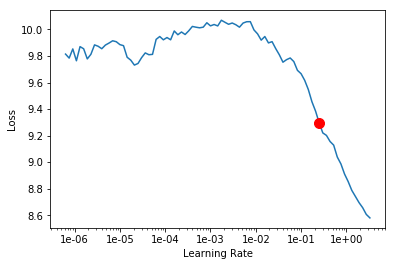

In [74]:
learn.load('stage_0')
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [76]:
epochs = 50         # ✳️ 
max_lr = 1e-1        # ✳️ 
warmup = False       # ✳️
pct_start = .7       # ✳️
metrics = [mean_absolute_error] # ✳️
wd = 1e-2

In [77]:
learn.metrics = metrics
learn.load('stage_0')
learn.fit_one_cycle(epochs, max_lr=max_lr, pct_start=pct_start, moms=(.95, .85) if warmup else (.95, .95),
                    div_factor=25.0 if warmup else 1., wd=wd)
learn.save('stage_1')
learn.recorder.plot_lr()
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,mean_absolute_error,time
0,6.218374,6.287014,6.251780,00:30
1,6.074411,6.346800,6.434933,00:30
2,6.206858,6.344857,6.351645,00:31
3,6.173813,6.305717,6.348516,00:31
4,6.111846,6.357029,6.337534,00:32
5,6.065244,6.303162,6.295411,00:31
6,6.058973,6.315233,6.315572,00:31
7,6.032767,6.312510,6.324657,00:31
8,6.160506,6.295669,6.250458,00:31
9,6.196882,6.301906,6.280305,00:31


KeyboardInterrupt: 

In [ ]:
test_data = TimeSeriesList(X_test)
db.add_test(test_data)

In [ ]:
preds, _ = learn.get_preds(DatasetType.Test)

In [ ]:
mae(preds,torch.tensor(y_test))

The model seems to train as intended, but doesn't learn anything useful. It even performs worse than a simple average over the window. It's not suprising that it wouldn't perform BETTER - there may just not be much information beyond the average. But it's odd that it performs so much WORSE - it ought to be able to learn to compute an average. So I suspect something is wrong in the setup.

In [37]:
# older make features, with various stuff I tested that I want to hold onto

def make_features(pdf):
    # categorical features
#     pdf = pdf.assign(
#         opponent=pdf['MATCHUP'].apply(lambda x: x.split()[-1]),
#         team=pdf['TEAM_ABBREVIATION']
#     )

#     cat_features = ['team', 'opponent']

    # create date features
#     pdf = pdf.assign(
#         dayofweek=pdf['date'].dt.weekday,
#         quarter=pdf['date'].dt.quarter,
#         month=pdf['date'].dt.month,
#         year=pdf['date'].dt.year,
#         dayofmonth=pdf['date'].dt.day,
#         dayofyear=pdf['date'].dt.dayofyear,
#         weekofyear=pdf['date'].dt.weekofyear,
#         days_since_game=(pdf['date'] - pdf['date'].shift()).dt.days
#     )

    date_features = ['dayofweek', 'quarter', 'month', 'year',
           'dayofmonth', 'dayofyear', 'weekofyear', 'days_since_game']

    cont_features = ['MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
           'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK',
           'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'NBA_FANTASY_PTS']

    # statistical features
    focus = 'PTS'
    
    pdf = pdf.assign(
        target=pdf[focus].shift(-1),
        sample_mean=pdf[focus].expanding().mean(),
        ewma=pdf[focus].ewm(alpha=0.1).mean(),
        last_day=pdf[focus],
        home=pdf['MATCHUP'].shift(-1).apply(lambda x: x if type(x)==np.float else int(x.split()[1]=='vs.'))
    )
    # you could also try these same sort of statistical features for other raw values
    
    stat_features = [last_day', 'sample_mean', 'ewma', 'home', 'target']
    
    #     features = pdf[cat_features + date_features + cont_features + stat_features].copy()
    features = pdf[stat_features].copy()

    features = features[1:-1] # drop rows with missing data

    return features